# $\textbf {TMA4320 - Prosjekt 2}$


# Introduksjon 

## Modellen
I denne oppgaven skal vi benytte oss av dyplæring til å utføre en binær klassifisering av ulike typer bilder. Modellen vi bruker er et nevralt nettverk med $K$ antall lag. Hvert lag har et sett med parametre, og sammenlagt kan vi uttrykke alle parametre i modellen ved $\textbf{U} = [(W_k,b_k)^{K-1}_{k=0},\omega,\mu]$. Videre  gir vi modellen et antall $I$ treningsbilder, alle med dimensjon $d$. Disse kan representeres som kolonnevektorer i matrisen $\textbf{Y}$. Bildene transformeres i hvert lag med transformasjonen

$\textbf{Y}_{k+1} = \textbf{Y}_k + h\sigma(W_k\textbf{Y}_k + b_k)$.

der $h$ er skrittlengden og $\sigma$ er en aktiveringsfunksjon. Etter å ha gått gjennom alle lagene projiserer vi de transformerte bildene på en skalar. Til sammen får vi vektoren $Z$. Målet er at $Z$ skal gi en riktig binær klassifisering av bildene. For å måle avviket fra den riktige klassifiseringen bruker vi kostfunksjonen:

$J = \frac{1}{2}\sum^I_{i=1}|Z_i - c_i|^2$

der $c_i$ er den riktige binære klassifiseringen til bilde nummer $i$. Resten av algoritmen går ut på å regne ut gradienten til $J$, for å kunne minimere den, ved å endre på parameterne $\textbf{U}$. For å gjøre dette kan man benytte blant annet metodene plain vanilla og Adam descent. I vår kode har vi brukt sistnevnte. 

Vi gjentar den ovennevnte prosessen et antall $\tt{iterations}$ ganger. Dette kalles treningsfasen. Når den er ferdig går vi inn i valideringsfasen. Da  kjører vi et helt nytt sett med bilder gjennom modellen, med parameterne funnet i treningsfasen, og observerer hvor mange riktige klassifiseringer vi får. Det er viktig å nevne at vi har brukt en toleranse for å bestemme om klassifiseringen er riktig, da skalarene i $Z$ sjelden vil være akkurat 1 eller 0.

## Rapportens struktur
Først presenteres algoritmen, deretter testproblem 1, og til slutt testproblem 2.

$\textbf{I testproblem 1}$ skal punkter i planet klassifiseres. Det skal skilles mellom to typer punkter. Her er de valgt til å være henholdsvis røde og blå. "Bildet" i dette problemet er dermed et punkt, kun beskrevet av to koordinater $(x,y)$. Modellen skal dermed trenes til å avgjøre om et vilkårlig punkt er rødt eller blått.

$\textbf{I testproblem 2}$ skal siffer fra MNIST klassifiseres. Her er det snakk om virkelige bilder med lav oppløsning. Størrelsen på bildene er 28 x 28 piksler. Bildene i settene fra MNIST består av siffer fra 0-9, dvs 10 ulike klasser av bilder. For at dette skal passe inn i vår binære klassifiseringsmodell holder vi oss til kun to forskjellige siffer om gangen, som for eksempel 2 og 7. 


## Modell og algoritme


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from spirals import*
from plotting import* 
from loader import*
import pickle

def sigma(x):
    ''' Aktiveringsfunksjonen '''
    return np.tanh(x)

def sigma_der(x):
    ''' Aktiveringsfunksjonens deriverte '''
    return 1-(np.tanh(x))**2  

def eta(x):
    ''' Skalar funksjon for projeksjon på en skalar '''
    return 0.5*(1+sigma(x/2))

def eta_der(x):
    ''' Den skalare funksjonen eta(x) sin deriverte '''
    return 0.25*sigma_der(x/2)    

def adam_method(x, x_der, m_jn, v_jn, j):
    ''' Adam Descent Algorithm '''
    beta_1 = 0.9
    beta_2 = 0.999
    alfa = 0.01
    epsilon = 1e-8
    m_j = beta_1*m_jn + (1-beta_1)*x_der
    v_j = beta_2*v_jn + (1-beta_2)* (x_der*x_der)
    m_hatt_j = m_j/(1-beta_1**(j))
    v_hatt_j = v_j/(1-beta_2**(j))
    val = alfa*m_hatt_j/(np.sqrt(v_hatt_j) + epsilon)
    x -= val
    return x, m_j, v_j

def set_random_parameters(K, d, I):
    ''' Setter random startverdier for vekter og bias i alle lag '''
    W_k = np.random.randn(K,d,d)
    b_k = np.random.randn(K,d,1)
    b_k_dim = np.zeros((K,d,I))
    b_k_dim[:,:,:] = b_k[:,:,:]  
    omega = np.random.randn(d)     
    my = np.random.rand() 
    return W_k, b_k_dim, omega, my

def initialize(K,d,I):
    ''' Initialiserer alle nødvendige matriser/lister for bokføring gjennom treningen '''
    Y_Kk = np.zeros((K+1,d,I))
    J_der_W = np.zeros((K,d,d))
    J_der_b_dim = np.zeros((K,d,I))
    vec_II = np.ones((I,I))  #For matrisemultiplikasjon senere
    P_Kk = np.zeros((K,d,I))
    
    #Til Adam-metoden:
    v_j = np.array([0,np.zeros(d),np.zeros((K,d,I)),np.zeros((K,d,d))])
    m_j = np.array([0,np.zeros(d),np.zeros((K,d,I)),np.zeros((K,d,d))])
    return Y_Kk, J_der_W, J_der_b_dim, vec_II, P_Kk, m_j, v_j

def stochastic_gradient_descent(Y_0, C, I_tot, chunk): 
    ''' Stochastic Gradient Descent: Plukker ut er antall (chunk) bilder som kjøres gjennom modellen om gangen. 
        Supplement til Adam Descent Algorithm '''
    start = np.random.randint(I_tot-chunk)
    Y0_chunk = Y_0[:,start:start+chunk] 
    C_chunk = C[start:start+chunk]
    return Y0_chunk, C_chunk 

def calculate_YKk_and_Z(my, omega, b_k_dim, W_k, Y_Kk, h, K):
    ''' Beregner verdiene Y_K og projiserer på skalar Z '''
    for i in range(K):
        Y_Kk[i+1] = Y_Kk[i] + h*sigma(W_k[i] @ Y_Kk[i] + b_k_dim[i]) 
    
    Z = eta(np.transpose(Y_Kk[-1]) @ omega + my)  
    return Y_Kk, Z

def calculate_projection_derivatives(my, omega, Y_Kk, Z, c):
    ''' Beregner del (5) og (6) av gradienten til kostfunksjonen J '''
    YT_k = np.transpose(Y_Kk[-1])  
   
    J_der_my = np.transpose(eta_der(YT_k @ omega + my)) @ (Z-c) 
    J_der_omega = Y_Kk[-1] @ ((Z-c) * eta_der(YT_k @ omega + my))
    return J_der_my, J_der_omega

def calculate_rest_of_gradient(my, omega, b_k_dim, W_k, Y_Kk, Z, c, h, K, P_Kk, J_der_W, J_der_b_dim, vec_II):
    ''' Beregner de gjenstående delene av gradienten til kostfunksjonen J: 
        J sin partiellderiverte med hensyn på W_k og b_k. Beregner også P_k og P_k_1. '''
    YT_k = np.transpose(Y_Kk[-1])   
    P_k = np.outer(omega,(Z-c)*eta_der(YT_k @ omega + my))
    P_Kk[-1] = P_k      

    for i in range(K-1,0,-1): 
        P_Kk[i-1] = P_Kk[i] + h*np.transpose(W_k[i-1]) @ (sigma_der(W_k[i-1] @ Y_Kk[i-1] +b_k_dim[i-1]) * P_Kk[i])
    
    for i in range(K):
        val = P_Kk[i] * sigma_der(W_k[i] @ Y_Kk[i] + b_k_dim[i])
        J_der_W[i] = h*(val @ np.transpose(Y_Kk[i]))
        J_der_b_dim[i] = h*(val @ vec_II)
        
    return J_der_W, J_der_b_dim

def algorithm(Y_0, c, K, d, iterations, h, I, chunk): 
    ''' Algoritmen som brukes til trening av modellen '''
    j = 1
    J = np.zeros(iterations)
    
    stochastic_method = False
    if chunk < I: # then use Stochastic method
        I_tot = I  #new variable name
        I = chunk  #to get right dimensions below
        Y_0_tot = Y_0
        c_tot = c
        stochastic_method = True
    
    W_k, b_k_dim, omega, my = set_random_parameters(K, d, I)
    Y_Kk, J_der_W, J_der_b_dim, vec_II, P_Kk, m_j, v_j = initialize(K, d, I)
    
    while j <= iterations:
        if stochastic_method:
            Y_0, c = stochastic_gradient_descent(Y_0_tot, c_tot, I_tot, chunk)
        
        Y_Kk[0] = Y_0
        Y_Kk, Z = calculate_YKk_and_Z(my, omega, b_k_dim, W_k, Y_Kk, h, K) 
        
        J[j-1] = 0.5*np.linalg.norm(Z-c)**2
        
        J_der_my, J_der_omega = calculate_projection_derivatives(my, omega, Y_Kk, Z, c) 
        
        J_der_W, J_der_b_dim = calculate_rest_of_gradient(my, omega, b_k_dim, W_k, Y_Kk, Z, c, h, K, P_Kk, J_der_W, J_der_b_dim, vec_II)
        
        my, m_j[0],v_j[0] = adam_method(my, J_der_my, m_j[0], v_j[0], j)
        omega, m_j[1],v_j[1] = adam_method(omega,J_der_omega,m_j[1],v_j[1], j)
        b_k_dim, m_j[2],v_j[2] = adam_method(b_k_dim,J_der_b_dim,m_j[2],v_j[2], j)
        W_k, m_j[3],v_j[3] = adam_method(W_k,J_der_W,m_j[3],v_j[3], j)
        
        j+= 1
    return my, omega, b_k_dim, W_k, Y_Kk, J, Z, c 

#blir brukt til å plotte punktene
def forward_function(grid):
    ''' A function that takes one argument, an S-by-2 matrix of S datapoints, and
        returns a vector of S classification values.'''   
    b_k_dim_grid = np.zeros((K,d,len(grid[0,:])))
    b_k = np.reshape(b_k_dim[:,:,0], b_k_dim[:,:,0].shape + (1,))
    b_k_dim_grid[:,:,:] = b_k[:,:,:]
    grid_Kk = np.zeros((K+1,d,len(grid[0,:])))
    grid_Kk[0] = grid
    grid_Kk, Z = calculate_YKk_and_Z(my, omega, b_k_dim_grid, W_k, grid_Kk, h, K)
    return Z

def last_function(grid):
    ''' A function that takes one argument, and S-by-2 matrix of S intermediate states in
        the network, and retruns a vector of S classification values.
        It should multiply by w, add μ and evaluate 𝜂.'''
    Z = eta(np.transpose(grid) @ omega + my)
    return Z

def plot_cost_function_convergence(iterations, J):
    '''' Plotter konvergens av kostfunksjonen som en funksjon av iterasjonsindex ''' 
    j_values = [i for i in range(1,iterations+1)]
    plt.figure()
    plt.plot(j_values, J)
    plt.xlabel("Iterasjons indeks j")
    plt.ylabel(r"$\mathcal{J}$", fontsize=20)
    plt.title("Konvergens av kostfunksjonen J")
    plt.show()

def print_successrate(Z, c, tol=0.5):
    ''' Printer suksessrater: andel av punktene som er rett klassifisert '''
    correctly_classified = 0
    for i in range(len(Z)):
        if abs(Z[i]-c[i]) <= tol:
            correctly_classified+=1
    print("Ratio av korrekte klassifiserte punkter:", correctly_classified/len(c))
    print("(med en toleranse på differansen mellom klassifiserte punkter og labelene:",str(tol)+")")

def write_to_file(my, omega, b_k_dim, W_k, filename):
    ''' Skriver parameterlisten U til fil (binært) '''
    U = [my, omega, b_k_dim, W_k]
    with open(filename, "wb") as f:
        pickle.dump(U, f)

def test_parameters(Y_0, h, K, d, I, filename):
    ''' Tester parametere lest inn fra fil '''
    with open(filename, "rb") as f:
        U = pickle.load(f)
    my, omega, b_k_dim, W_k = U[0], U[1], U[2], U[3]
    
    Y_Kk = np.zeros((K+1,d,I))
    Y_Kk[0] = Y_0
    Y_Kk, Z = calculate_YKk_and_Z(my, omega, b_k_dim, W_k, Y_Kk, h, K)
    return Y_Kk, Z

def show_image(Y_k, n):
    ''' Viser de n første bildene i Y_k '''
    for i in range(n):
        image = Y_k[:,i].reshape((28,28))
        plt.axis("off")
        plt.imshow(image, cmap="binary")
        plt.show()

## Testproblem 1 - punkter i planet

I presentasjonen av resultatene for testproblem 1 ser vi på to konfigurasjoner der vi varierer $h$ og $K$. I den første gir modellen høy konvergens, mens i den andre gir den forholdsvis lav konvergens, i betydningen kostfunksjonen $J$'s konvergens. Til slutt presenteres en tabell over suksessrater i valideringsfasen og en kort diskusjon rundt resultatene.

### Treningsfase - høy konvergens

I første omgang ønsker vi å presentere et eksempel der modellen klassifiserer godt. Kostfunksjonens konvergens plottes mot iterasjonsindeksen. Den siste verdien til kostfunksjonen blir også skrevet ut.

Basert på tabellen over suksessrater, som presenteres lenger ned, gir konfigurasjonen nedenfor en god klassifisering.

Ratio av korrekte klassifiserte punkter: 1.0
(med en toleranse på differansen mellom klassifiserte punkter og labelene: 0.05)
Siste verdien til J-funksjonen:  1.2426795704072366e-10


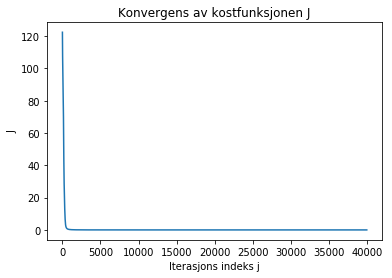

In [13]:
h = 0.1
K = 20

d = 2
I = 1000   
iterations = 40000
chunk = I

Y_0, c = get_data_spiral_2d(I)
c = c[:,0]

my, omega, b_k_dim, W_k, Y_Kk, J, Z, c = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)
write_to_file(my, omega, b_k_dim, W_k, "good_example.txt")

print_successrate(Z,c, tol=0.05)
print("Siste verdien til J-funksjonen: ", J[-1])
plot_cost_function_convergence(iterations, J)

### Valideringsfase - høy konvergens

Her hentes parameterne som ble funnet i treningsfasen, og blir testet på nye verdier.
Transformasjonen av punktene plottes også for hvert lag i modellen. I progresjons-plottene er punktene testdata. I de to siste plottene er testdata representert som et kontinuerlig fargespektrum, mens treningsdata er representert ved punktene.

Ratio av korrekte klassifiserte punkter: 0.993
(med en toleranse på differansen mellom klassifiserte punkter og labelene: 0.05)
Ratio av korrekte klassifiserte punkter: 0.991
(med en toleranse på differansen mellom klassifiserte punkter og labelene: 1e-05)


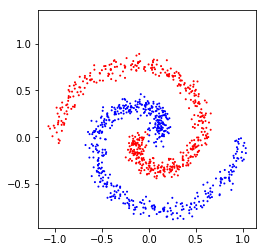

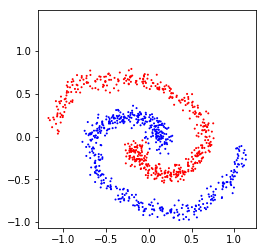

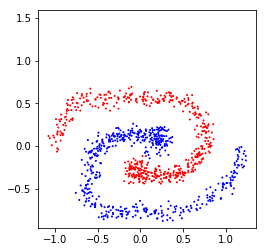

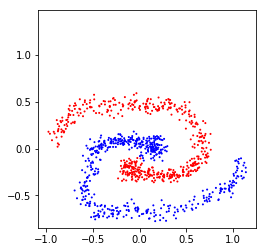

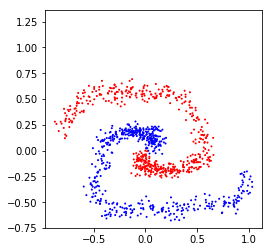

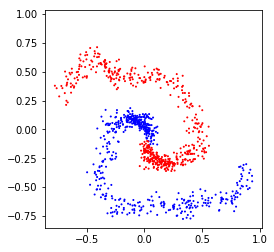

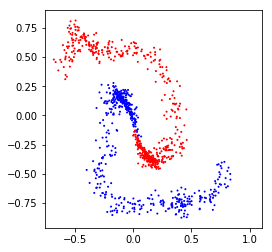

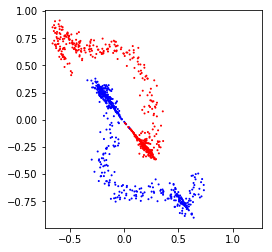

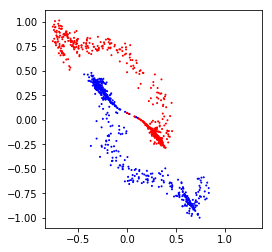

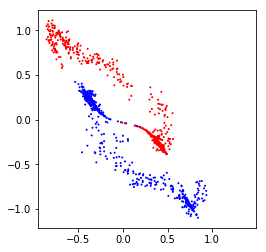

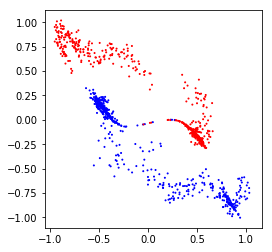

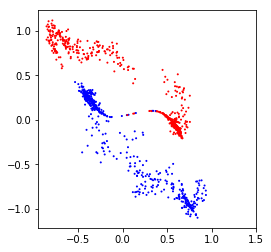

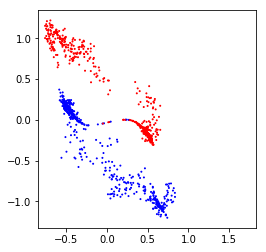

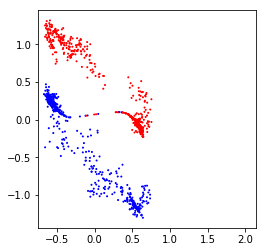

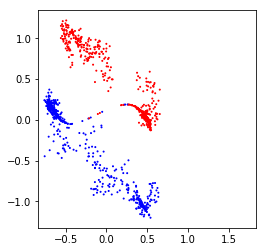

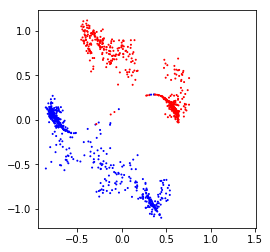

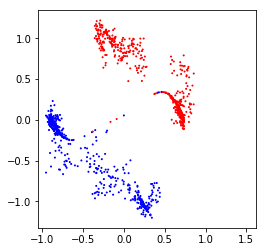

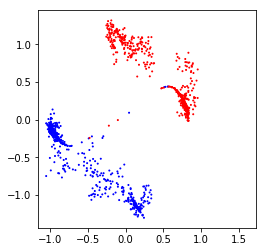

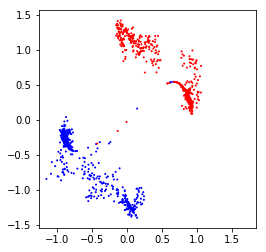

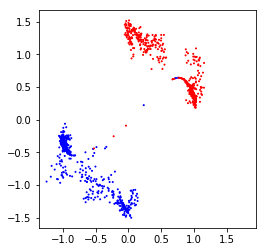

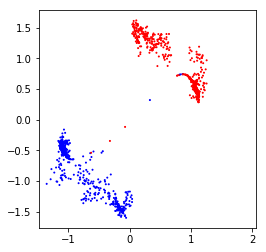

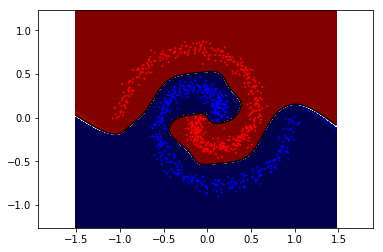

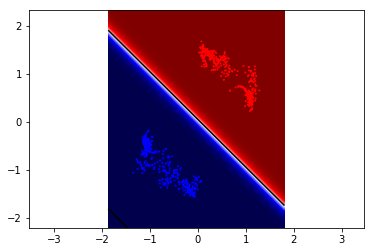

In [19]:
Y_0, c_test = get_data_spiral_2d(I)
Y_Kk_test, Z_test = test_parameters(Y_0, h, K, d, I, "good_example.txt")
print_successrate(Z_test, c_test, tol=0.05)
print_successrate(Z_test, c_test, tol=1e-5)

plot_progression(Y_Kk_test, c_test)
plot_model(forward_function,Y_Kk[0,:,:],c,1000)
plot_separation(last_function,Y_Kk[-1,:,:],c,1000)

### Treningsfase - lav konvergens

I neste omgang ønsker vi å presentere et eksempel der modellen har lav suksessrate i forhold til de andre resultatene presentert i tabellen under. Kostfunksjonens konvergens plottes mot iterasjonsindeksen. Den siste verdien til kostfunksjonen blir også skrevet ut.

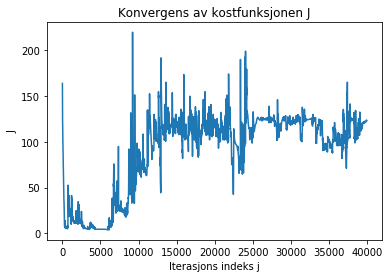

Ratio av korrekte klassifiserte punkter: 0.0
(med en toleranse på differansen mellom klassifiserte punkter og labelene: 0.05)
Siste verdi i J: 123.16614361562212


In [7]:
h = 0.7
K = 17    

d = 2
I = 1000   
iterations = 40000  
chunk = I

Y_0, c = get_data_spiral_2d(I)
c = c[:,0]

my, omega, b_k_dim, W_k, Y_Kk, J, Z, c = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)
write_to_file(my, omega, b_k_dim, W_k, "bad_example.txt")

plot_cost_function_convergence(iterations, J)
print_successrate(Z, c, tol=0.05)
print("Siste verdi i J:", J[-1])

### Valideringsfase - lav konvergens

Her hentes parameterne som ble funnet i treningsfasen, og blir testet på nye verdier.
Transformasjonen av punktene plottes også for hvert lag i modellen. I progresjons-plottene er punktene testdata.

In [43]:
Y_0, c_test = get_data_spiral_2d(I)
c_test = c_test[:,0]

Y_Kk_test, Z_test = test_parameters(Y_0, h, K, d, I, "bad_example.txt")
print_successrate(Z_test, c_test, tol=0.05)

#Skal vi ha Y_test?
plot_progression(Y_Kk_test, c_test)
#plot_model(forward_function,Y_Kk[0,:,:],c,1000)
#plot_separation(last_function,Y_Kk[-1,:,:],c,1000)

ValueError: could not broadcast input array from shape (2,1000) into shape (784,1000)

### Suksessrater: 

Modellen har blitt trent og testet en rekke flere ganger. Suksessratene  fra valideringsfasen i disse kjøringene er presentert i tabellen nedenfor. 

Modellen er trent med 40000 iterasjoner og 1000 bilder, samt varierende verdier av $K$ og $h$, som vist i tabellen, for alle kjøringene. Antall lag K og skrittlengden h i transformasjonene er altså variert for å skille mellom gode og dårlige konfigurasjoner. Det er viktig å få fram at disse er kjørt en gang, noe som medfører at det ikke er statistiske data. De kan altså ikke brukes til å konkludere med hvilke som er best eller dårligst ved bruk. Derimot er dette de umiddelbare resultatene, som fortsatt kan gi en slags pekepinn. Tilliten til konklusjonen man eventuelt måtte trekke fra tabellen kan anses som lav.  


| tol = 0.05 | K = 5 | K = 7 | K = 10 | K = 15 | K = 17 | K = 20 |
|------------|-------|:-----:|--------|--------|--------|--------|
| h = 0.1    | 0.069 | 0.437 | 0.997  | 0.997  | 0.996  | 0.999  |
| h = 0.3    | 0.153 | 0.888 | 0.998  | 0.996  | 0.997  | 0.234  |
| h = 0.5    | 0.930 | 0.565 | 0.010  | 0.364  | 0.997  | 0.217  |
| h = 0.7    | 0.077 | 0.576 | 0.998  | 0.997  | 0.0    | 0.985  |
| h = 0.9    | 0.914 | 0.344 | 0.848  | 0.0    | 0.678  | 0.995  |


Toleransen ble satt til 0.05 under klassifiseringen i denne oppgaven. Under valideringsfasen i det gode eksempelet ser vi at en toleranse på 0.05 og 1e-5 gir omtrent samme suksessrate ettersom verdiene i projeksjonen $Z$ er såpass nærme 0 eller 1.  


Det er ganske åpnebart at modellen blir bedre trent med flere lag. Derimot kan disse resultatene vise at man kan få tilnærmet like gode resultater med færre lag. Basert på denne tabellen kan man trekke en slutning, med tilhørende svak tillit, som allerede nevnt, om at de siste 10 lagene vi har kjørt tester for ikke utgjør veldig mye på resultatet. Derimot ser man at forskjellen i suksessrate fra $K = 7$ til $K = 10$ er vesentlig. Det kan tyde på at de drastiske endringene mot konvergens av kostfunksjonen skjer i løpet av første 10 lagene omtrent, noe som betyr at de siste 10 lagene blir overflødige. Dette er dermed et eksempel på hvordan man kan effektivisere modellen, uten å miste noe særlig presisjon i resultatene. Det ser også ut til å gi bedre resultater når $h$ er mindre. Da konvergere også kostfunksjonen, slik som i det gode eksempelet, i motsetning til flere av kjøringene med høyere skrittlengde, slik det svake eksempelet viser for det tilfellet. 


## Testproblem 2 - håndskrevne siffer

Her skal dataene presenteres på en litt annen måte enn i testproblem 1. Vi ønsker å illustrere forskjellen i nøyaktighet for modellen når den trenes og testes med diverse sifre. Modellen er kjørt med 2 og 7, samt 4 og 9, som anses som relativt like siffer. Dermed burde klassifiseringen være mindre god for disse. I tillegg trenes og testes modellen med 1 og 8. Da disse er mye mer ulike burde klassifiseringen være bedre enn de to andre tilfellene. Suksessrate skrives fortsatt ut til skjerm både under trening og testing i hver av tilfellene, samt at kostfunksjonens konvergens plottes. 


Ratio av korrekte klassifiserte punkter: 0.93
(med en toleranse på differansen mellom klassifiserte punkter og labelene: 0.05)
Siste verdien til J-funksjonen:  3.5000000000000004


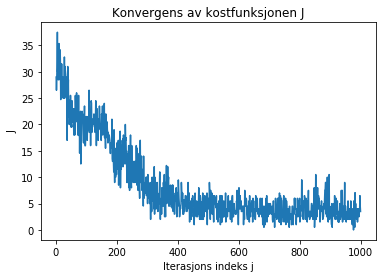

In [30]:
K = 10
h = 0.3

d = 784
chunk = 100       
iterations = 1000

Y_0, c = get_dataset("training", 2, 7)
c = c[:,0]

my, omega, b_k_dim, W_k, Y_Kk, J, Z, c  = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)
write_to_file(my, omega, b_k_dim, W_k, "parameters_2&7.txt")

print_successrate(Z, c, tol=0.05)
print("Siste verdien til J-funksjonen: ", J[-1])
plot_cost_function_convergence(iterations, J)

**Tester parameterene**

Ratio av korrekte klassifiserte punkter: 0.9
(med en toleranse på differansen mellom klassifiserte punkter og labelene: 0.05)
Første bildet i et tilfeldig utvalg av Y_0.


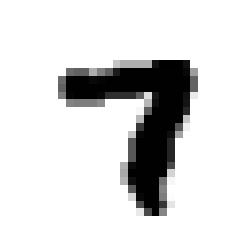

Samme bildet transformert 5 ganger.


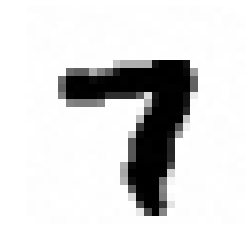

In [41]:
Y_0, c = get_dataset("testing", 2, 7)

Y_0_test, c_test = stochastic_gradient_descent(Y_0, c, len(Y_0[0,:]), chunk)
Y_Kk_test, Z_test = test_parameters(Y_0_test, h, K, d, chunk, "parameters_2&7.txt")

print_successrate(Z_test,c_test, tol=0.05)


print("Første bildet i et tilfeldig utvalg av Y_0.")
show_image(Y_0_test, 1)

print("Samme bildet transformert", K, "ganger.")
show_image(Y_Kk_test[-1], 1)

Suksessrater for validering av modellen med siffrene 2 og 7. Antall iterasjoner og chunk er fastsatte verdier på henholdsvis 1000 og 100. 


| tol = 0.05 | K = 5 | K = 10 | K = 15 |
|------------|-------|--------|--------|
| h = 0.1    | 0.91  |  0.96  | 0.93   |
| h = 0.3    | 0.94  |  0.97  | 0.95   |
| h = 0.9    | 0.92  |  0.92  | 0.94   |

Velger konfigurasjonen $K=10$ og $h=0.3$ som tydeligvis skal  

Ser også at bildene ikke endrer seg, da pga av det er i d-dimensjoner.!!ø

## Siffer 4 og 9

Med samme parametere tester vi på to andre siffere; her 1 og 9.
Ratio av korrekte klassifiserte punkter: 0.98
(med en toleranse på differansen mellom klassifiserte punkter og labelene: 0.05)
Første bildet i et tilfeldig utvalg av Y_0.


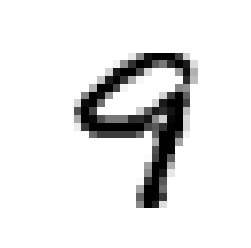

Samme bildet transformert 15 ganger.


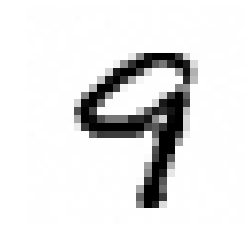

In [90]:
Y_0, c = get_dataset("training", 4, 9)
c = c[:,0]

my, omega, b_k_dim, W_k, Y_Kk, J, Z, c  = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)
write_to_file(my, omega, b_k_dim, W_k, "parameters_4&9.txt")

print("Etter treningsfasen: ")
print_successrate(Z, c, tol=0.05)
print("Siste verdien til J-funksjonen: ", J[-1])
plot_cost_function_convergence(iterations, J)


Y_0, c = get_dataset("testing", 4, 9)
print("Etter testfasen: ")
Y_0_test, c_test = stochastic_gradient_descent(Y_0, c, len(Y_0[0,:]), chunk)
Y_Kk_test, Z_test = test_parameters(Y_0_test, h, K, d, chunk, "parameters_4&9.txt")

print_successrate(Z_test,c_test, tol=0.05)

## Siffer 1 og 8

Etter treningsfasen: 
Ratio av korrekte klassifiserte punkter: 0.93
(med en toleranse på differansen mellom klassifiserte punkter og labelene: 0.05)
Siste verdien til J-funksjonen:  3.5000000000000004


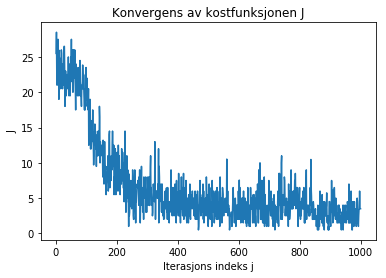

Etter testfasen: 
Ratio av korrekte klassifiserte punkter: 1.0
(med en toleranse på differansen mellom klassifiserte punkter og labelene: 0.05)


In [44]:
Y_0, c = get_dataset("training", 1, 8)
c = c[:,0]

my, omega, b_k_dim, W_k, Y_Kk, J, Z, c  = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)
write_to_file(my, omega, b_k_dim, W_k, "parameters_1&8.txt")
print("Etter treningsfasen: ")
print_successrate(Z, c, tol=0.05)
print("Siste verdien til J-funksjonen: ", J[-1])
plot_cost_function_convergence(iterations, J)


Y_0, c = get_dataset("testing", 1, 8)
print("Etter testfasen: ")
Y_0_test, c_test = stochastic_gradient_descent(Y_0, c, len(Y_0[0,:]), chunk)
Y_Kk_test, Z_test = test_parameters(Y_0_test, h, K, d, chunk, "parameters_1&8.txt")

print_successrate(Z_test,c_test, tol=0.05)

## Konklusjon?
